In [20]:
from scripts.graph_constructors.GraphConstructor import TextGraphType
import os
from scripts.graph_data_modules.AGGraphDataModule import AGGraphDataModule
import torch
from torch.utils.flop_counter import FlopCounterMode
from scripts.configs.ConfigClass import Config


""" Change the following path to the project root folder"""
root_folder = r'C:\Users\fardin\Projects\BeyondWordsSimplified'
config = Config(root_folder)
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 256


In [2]:
from scripts.models.HeteroDeepGraphEmbedding6 import HeteroDeepGraphEmbedding6

In [3]:
from scripts.lightnings.LightningModels import HeteroMultiClassLightningModel
from scripts.loss_functions.HeteroLossFunctions import MulticlassHeteroLoss1, MulticlassHeteroLoss2, MulticlassHeteroLoss3
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
import lightning as L
from lightning.pytorch.tuner import Tuner
from scripts.managers.ClassifierModelManager import ClassifierModelManager

In [4]:
graph_type = TextGraphType.SEQUENTIAL
data_manager = AGGraphDataModule(config, test_size=0.00, val_size=0.05511811, shuffle=False, start_data_load=0 , end_data_load = 7000 , device='cpu', batch_size=batch_size, graph_type=graph_type, load_preprocessed_data = True)
data_manager.load_labels()
data_manager.load_graphs()

filename: C:\Users\fardin\Projects\BeyondWordsSimplified\data/GraphData/AG\seq_gen\graph_var.txt


 Loding Graphs From File : 100%|██████████| 7/7 [00:30<00:00,  4.34s/it]


In [5]:
val_dataloader = data_manager.val_dataloader()
X3, Y3 = next(iter(val_dataloader))
from copy import copy
metadata = copy(X3.metadata())

In [6]:
from os import path
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, hinge_loss
import torchmetrics

def save_evaluation(model_mgr, eval_dataloader, name_prepend: str='',
                 give_confusion_matrix: bool=True, 
                 give_report: bool=True, 
                 give_f1_score: bool=False, 
                 give_accuracy_score: bool=False, 
                 give_precision_score: bool=False, 
                 give_recall_score: bool=False, 
                 give_hinge_loss: bool=False,
                 multi_class: bool=False
                 ):
        
        test_metrics_path = path.join(model_mgr.log_dir, model_mgr.log_name, f'version_{model_mgr.logger.version}', f'{name_prepend}_test_metrics.txt')
        
        y_true = []
        y_pred = []
        model_mgr.lightning_model.eval()
        model_mgr.lightning_model.model.eval()
        model_mgr.torch_model.eval()
        for X, y in eval_dataloader:
            model_mgr.trainer.model.eval()
            with torch.no_grad():
                y_p = model_mgr.trainer.model(X.to(model_mgr.device))
            if type(y_p) is tuple:
                y_p = y_p[0]
            
            if multi_class:
                y_pred.append(y_p.detach().to(y.device))
                y_true.append(y)
            else:
                y_pred.append((y_p>0).to(torch.int32).detach().to(y.device))
                y_true.append(y.to(torch.int32))
        y_true = torch.concat(y_true)
        y_pred = torch.concat(y_pred)
        print(y_true.shape)
        print(y_pred.shape)
        if multi_class:
            y_true_num = torch.argmax(y_true, dim=1)
            y_pred_num = torch.argmax(y_pred, dim=1)
        else:
            y_true_num = y_true
            y_pred_num = y_pred
            
        print(y_true_num.shape)
        print(y_pred_num.shape)
        with open(test_metrics_path, 'at+') as f:
            if(give_confusion_matrix):
                print(f'confusion_matrix: \n{confusion_matrix(y_true_num, y_pred_num)}', file=f)
            if(give_report):
                print(classification_report(y_true_num, y_pred_num), file=f)
            if(give_f1_score):
                if multi_class:
                    print(f'f1_score: {f1_score(y_true_num, y_pred_num, average=None)}', file=f)
                else:
                    print(f'f1_score: {f1_score(y_true_num, y_pred_num)}', file=f)
            if(give_accuracy_score):
                print(f'accuracy_score: {accuracy_score(y_true_num, y_pred_num)}', file=f)
            if(give_precision_score):
                if multi_class:
                    print(f'f1_score: {precision_score(y_true_num, y_pred_num, average=None)}', file=f)
                else:
                    print(f'f1_score: {precision_score(y_true_num, y_pred_num)}', file=f)
            if(give_recall_score):
                if multi_class:
                    print(f'f1_score: {recall_score(y_true_num, y_pred_num, average=None)}', file=f)
                else:
                    print(f'f1_score: {recall_score(y_true_num, y_pred_num)}', file=f)
            if(give_hinge_loss):
                print(f'hinge_loss: {hinge_loss(y_true_num, y_pred)}', file=f)


In [7]:
graph_embedding = HeteroDeepGraphEmbedding6(300, 4, metadata, 32, dropout=0.2, edge_type_count=1, active_keys = ['word'])
graph_embedding = graph_embedding.to(device)
flopt_counter = FlopCounterMode(graph_embedding)
with flopt_counter:
    graph_embedding(X3.to(device))

c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


Module                                          FLOP    % Total
------------------------------------------  --------  ---------
HeteroDeepGraphEmbedding6                   647.319M    100.00%
 - aten.addmm                               639.387M     98.77%
 - aten.mm                                    6.312M      0.98%
 - aten.convolution                           0.095M      0.01%
 - aten.bmm                                   1.524M      0.24%
 HeteroDeepGraphEmbedding6.hetero_linear1   224.429M     34.67%
  - aten.addmm                              224.429M     34.67%
 HeteroDeepGraphEmbedding6.hetero_gat_1      97.602M     15.08%
  - aten.addmm                               94.708M     14.63%
  - aten.mm                                   2.894M      0.45%
 HeteroDeepGraphEmbedding6.hetero_gat_2      97.602M     15.08%
  - aten.addmm                               94.708M     14.63%
  - aten.mm                                   2.894M      0.45%
 HeteroDeepGraphEmbedding6.mem_pool     

In [8]:
from typing import List
import torch
from torch import nn

from scripts.loss_functions.HeteroLossArgs import HeteroLossArgs

class MulticlassHeteroLoss2(torch.nn.Module):
    def __init__(self, exception_keys: List[str], enc_factor=0.0, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.cel_loss=  torch.nn.CrossEntropyLoss()
        self.mse_loss = torch.nn.MSELoss()
        self.exception_keys = exception_keys
        self.enc_factor = enc_factor
    
    def forward(self, out_pred: HeteroLossArgs, out_main: HeteroLossArgs):
        loss = self.cel_loss(out_pred.y, out_main.y)
        x_dict_keys = [k for k in out_pred.x_dict.keys() if k not in self.exception_keys]
        
        for key in x_dict_keys:
            tensor1 = out_pred.x_dict[key]
            tensor2 = out_main.x_dict[key]
            if tensor2.ndim == 1 and tensor2.dtype is torch.long:
                tensor2 = torch.nn.functional.one_hot(input=tensor2.to(torch.long), num_classes=tensor1.shape[1]).to(torch.float32)
            loss += self.enc_factor * (self.mse_loss(tensor1, tensor2))
        return loss

In [9]:
# Fardin Rastakhiz @ 2023
from torch import nn, Tensor
import torch.nn.functional as F
from torch_geometric.nn import BatchNorm

class HeteroLinear(nn.Module):
    
    def __init__(self, in_feature, out_feature, dropout = 0.2, use_dropout=True, use_batch_norm=False, use_activation=True) -> None:
        super().__init__()
        self.linear = nn.Linear(in_feature, out_feature)
        self.batch_norm = BatchNorm(out_feature)
        self.dropout= nn.Dropout(dropout)
        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout
        self.use_activation=use_activation

    def forward(self, x: Tensor) -> Tensor:

        x = self.linear(x)
        if self.use_batch_norm:
            x = self.batch_norm(x)
        if self.use_activation:
            x = F.leaky_relu(x)
        if self.use_dropout:
            x = self.dropout(x)
        return x

In [10]:
graph_embedding = HeteroDeepGraphEmbedding6(300, 4, metadata, 32, dropout=0.1, edge_type_count=1, active_keys=['word', 'general'])

In [18]:
y_pred = graph_embedding(X3.cpu())

Adjusting learning rate of group 0 to 4.5000e-03.


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbeddi

Epoch 1:  24%|██▍       | 6/25 [00:01<00:05,  3.50it/s, v_num=6, train_loss_step=0.799, train_acc_step=0.746, val_acc=0.692, train_loss_epoch=1.180, train_acc_epoch=0.490] 

c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


torch.Size([386, 4])
torch.Size([386, 4])
torch.Size([386])
torch.Size([386])


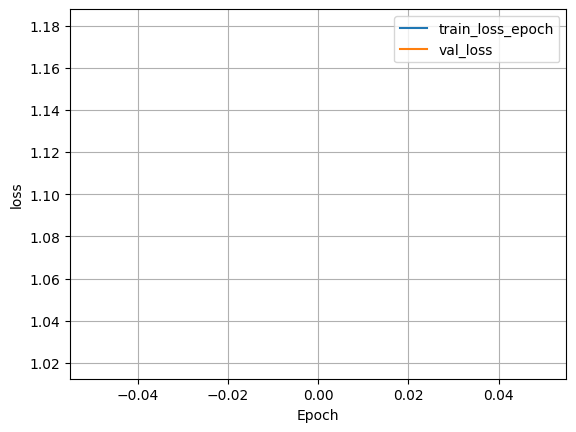

In [19]:
i=0
graph_embedding = HeteroDeepGraphEmbedding6(300, 4, metadata, 32, dropout=0.1, edge_type_count=1, active_keys=['word', 'general'])
graph_embedding = graph_embedding.to(device)
callbacks = [
ModelCheckpoint(save_top_k=5, mode='max', monitor='val_acc', save_last=True)
]
loss_func = MulticlassHeteroLoss2(exception_keys=['word'], enc_factor=0.0003)
optimizer = torch.optim.Adam(graph_embedding.parameters(), lr=0.0045, weight_decay=0.00125)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[6, 13, 28, 45, 60], gamma=0.5, verbose=True)
lightning_model = HeteroMultiClassLightningModel(graph_embedding, 4,
                                    optimizer=optimizer,
                                    loss_func=loss_func,
                                    learning_rate=0.045,
                                    batch_size=batch_size,
                                    user_lr_scheduler=True,
                                    lr_scheduler=lr_scheduler,
                                    min_lr=0.0005
                                    ).to(device)
lightning_model.model.to(device)
    
model_manager = ClassifierModelManager(graph_embedding, lightning_model, log_name='hetero_model_20_AG',device=device, num_train_epoch=70)
model_manager.fit(datamodule=data_manager)
model_manager.save_plot_csv_logger(loss_names=['train_loss_epoch', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc'], name_prepend=f'tests_{i}')
model_manager.torch_model = model_manager.torch_model.to(device)
save_evaluation(model_manager, data_manager.val_dataloader(), f'{i}',True, True, True, True, True, True, True, multi_class=True)